# NASA Turbofan Jet Engine Data Set
Run to Failure Degradation Simulation

This data set is the Kaggle version of the very well known public data set for asset degradation modeling from NASA. It includes Run-to-Failure simulated data from turbo fan jet engines.

# Prediction Goal
In this dataset the goal is to predict the **remaining useful life (RUL) of each engine in the test dataset. RUL is equivalent of number of flights remained for the engine after the last datapoint in the test dataset.**

# Import and process the data set

In [2]:
# import required libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.layers import Dense , LSTM, Dropout
from keras.models import Sequential, load_model
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [3]:
fd_001_train = pd.read_csv("CMaps/train_FD001.txt",sep=" ",header=None)

In [4]:
fd_001_test = pd.read_csv("CMaps/test_FD001.txt",sep=" ",header=None)

In [5]:
fd_001_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


In [6]:
#Going to drop last columns full of NaN values
fd_001_train.drop(columns=[26,27],inplace=True)
fd_001_test.drop(columns=[26,27],inplace=True)

In [7]:
#name of columns of dataset
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

In [8]:
fd_001_train.columns = columns
fd_001_test.columns = columns
fd_001_train.describe()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


Description of dataset

Consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are **three operational settings that have a substantial effect on engine performance**. These settings are also included in the data. The data is **contaminated with sensor noise.**

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, **the fault grows in magnitude until system failure**. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a **vector of true Remaining Useful Life (RUL) values for the test data.**


Este conjunto de datos consiste en múltiples series de tiempo multivariadas, donde cada serie de tiempo es de un motor diferente del mismo tipo. Los motores comienzan con diferentes grados de desgaste inicial y variación de fabricación, que son desconocidos para el usuario, y desarrollan una falla en algún momento durante la serie de tiempo. Los datos se dividen en conjuntos de entrenamiento y prueba. En el conjunto de entrenamiento, la falla crece en magnitud hasta la falla del sistema, mientras que en el conjunto de prueba, la serie de tiempo finaliza algún tiempo antes de la falla del sistema. El objetivo es predecir el número de ciclos operativos restantes antes de la falla en el conjunto de prueba, que es el número de ciclos operativos después del último ciclo en que el motor seguirá funcionando. El conjunto de prueba también incluye un vector de valores verdaderos de la vida útil restante del motor. Los datos están contaminados con ruido de sensor, y hay tres configuraciones operativas que tienen un efecto sustancial en el rendimiento del motor, que se incluyen en los datos.

Columnas:
1) unit number
2) time, in cycles
3) operational setting 1
4) operational setting 2
5) operational setting 3
6) sensor measurement 1
7) sensor measurement 2
...

26. sensor measurement 26

In [9]:
fd_001_train.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [10]:
#delete columns with constant values ​​that do not carry information about the state of the unit
fd_001_train.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

We will display the mutual correlations of the signs on the "heat map", for this we will prepare an additional sign "RUL", showing the number of cycles to failure in the training data¶

In [11]:
#function for preparing training data and forming a RUL column with information about the remaining
# before breaking cycles
def prepare_train_data(data, factor = 0):
    df = data.copy()
    #agrupar numero de unidad del motor y tiempo de ciclos maximo que lleva cada unidad
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    #creas df con solo estas dos columnas devueltas con el tiempo maximo de ciclos por cada unidad
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    #haces un join con el dataset original teniendo el tiempo maixmo ya par CADA UNIDAD
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    #Obtienes rul que es lo que se habra que predir, que es el tiempo de vida que le queda al motor
    df['RUL'] = df['max'] - df['time_in_cycles']
    #ya no te sirve max porque solo lo necesitabas para sacar RUL
    df.drop(columns=['max'],inplace = True)
    return df[df['time_in_cycles'] > factor]
df = prepare_train_data(fd_001_train)

In [12]:
df

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


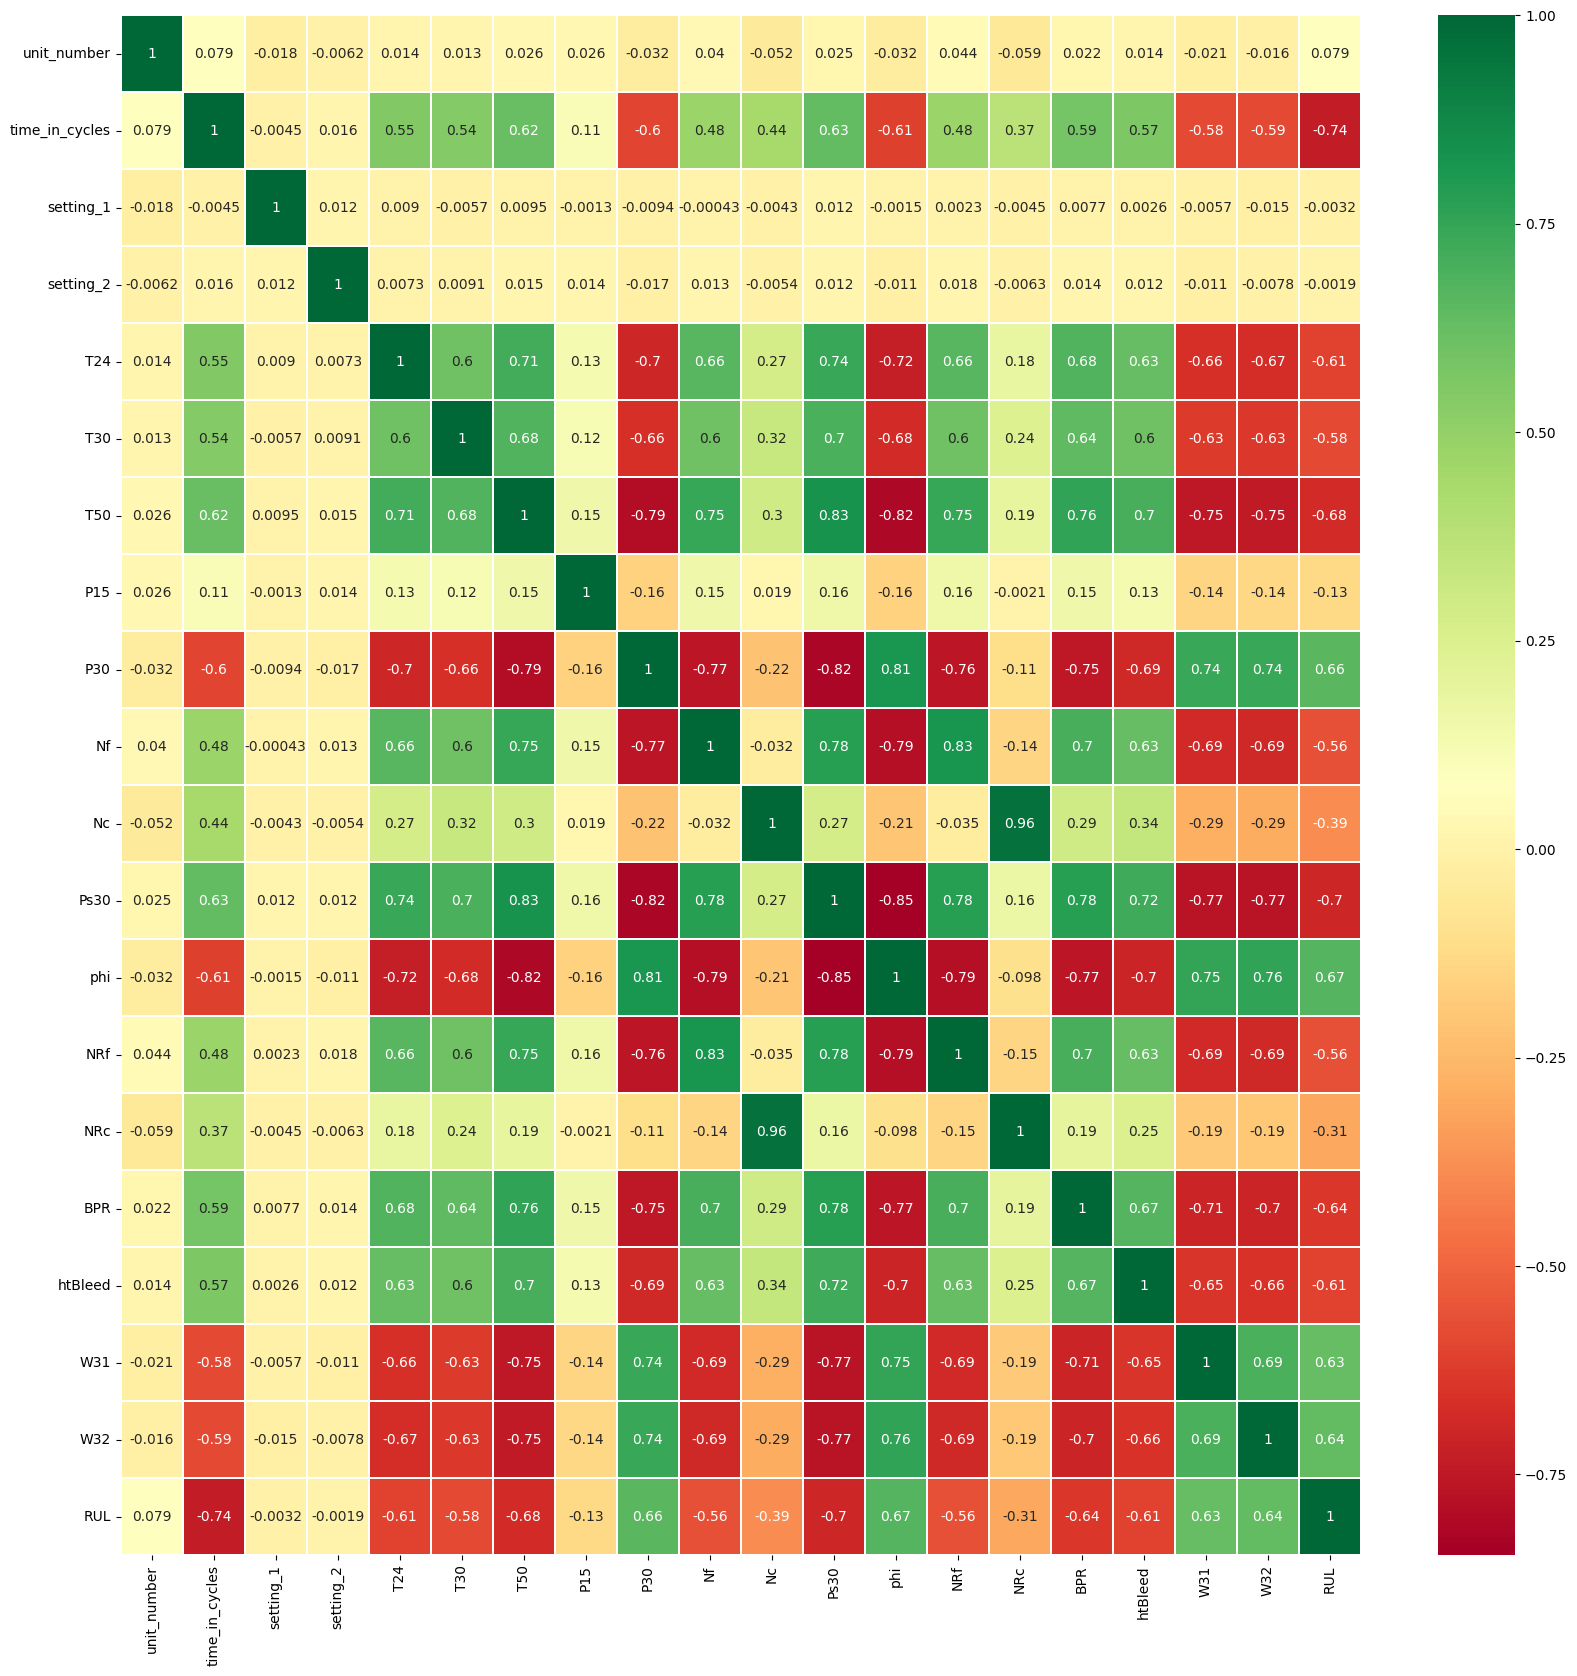

In [13]:
df = prepare_train_data(fd_001_train)
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

As it can be observed the following variables are the ones that hold the most direct and inverse relations with RUL

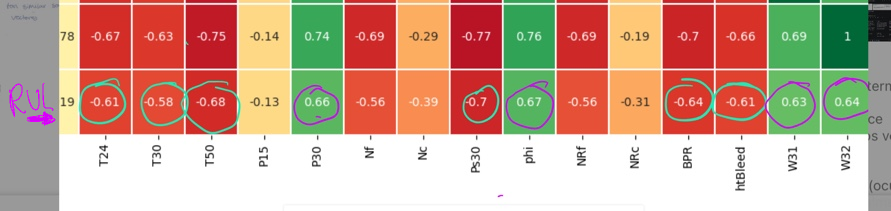

# Top 5 inverse strongest correlations 
- PS30 
- T50
- BPR
- htBleed and T24

# Top 4  strongest direct correlations 
- phi
- P30
- W32
- W31

Remove unsignificant columns

In [16]:
unit_number = pd.DataFrame(df["unit_number"])
train_df = df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc', 'RUL'])

In [18]:
y = df['RUL'].values
y

array([191, 190, 189, ...,   2,   1,   0], dtype=int64)

In [19]:
# Train y test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.3, random_state=29)

# Score for an Artificial Neural Network



In [41]:
num_features = X_train.shape[1]

In [61]:
import tensorflow as tf
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64, activation="relu",  input_shape=(num_features,)))
ann.add(tf.keras.layers.Dense(units=100, activation="relu")) 
ann.add(tf.keras.layers.Dense(units=30, activation="relu"))
ann.add(tf.keras.layers.Dense(units=1, activation="linear"))
ann

In [62]:
# Define custom RMSE metric
def rmse(y_true, y_pred):
    return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

# Register the custom metric with Keras
keras.utils.get_custom_objects()['rmse'] = rmse

In [63]:
ann.compile(optimizer="adam", loss="mean_squared_error", metrics=['mae', 'rmse'])

In [64]:
ann.fit(x=X_train, y=y_train, batch_size=32, epochs=100)

Epoch 1/100
452/452 [==============================] - 2s 1ms/step - loss: 6972.0996 - mae: 59.7566 - rmse: 71.7024
Epoch 2/100
452/452 [==============================] - 1s 1ms/step - loss: 2575.7751 - mae: 39.6504 - rmse: 50.0339
Epoch 3/100
452/452 [==============================] - 1s 1ms/step - loss: 2404.7820 - mae: 38.1131 - rmse: 48.3656
Epoch 4/100
452/452 [==============================] - 1s 1ms/step - loss: 2300.2913 - mae: 37.0022 - rmse: 47.2551
Epoch 5/100
452/452 [==============================] - 1s 1ms/step - loss: 2197.5576 - mae: 35.9285 - rmse: 46.2201
Epoch 6/100
452/452 [==============================] - 1s 1ms/step - loss: 2155.5139 - mae: 35.5151 - rmse: 45.8588
Epoch 7/100
452/452 [==============================] - 1s 1ms/step - loss: 2155.0476 - mae: 35.5552 - rmse: 45.7990
Epoch 8/100
452/452 [==============================] - 1s 1ms/step - loss: 2134.0676 - mae: 35.3085 - rmse: 45.6307
Epoch 9/100
452/452 [==============================] - 1s 1ms/step - los

In [65]:
loss, mae, rmse = ann.evaluate(X_test, y_test)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

194/194 [==============================] - 0s 953us/step - loss: 1708.8832 - mae: 32.1487 - rmse: 40.9026
Mean Absolute Error: 32.148746490478516
Root Mean Squared Error: 40.90256881713867


- 31

The goals are to get or better results:
 - mean absolute error 19.25
 - root mean squared error 24.45219826518671

# Linear regression model with Sklearn

In [74]:
from sklearn.linear_model import LinearRegression
import numpy as np
# create linear regression model object
lr_model = LinearRegression(fit_intercept = True)

# fit the model to the data
lr_model.fit(X_train, y_train)

LinearRegression()

In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# make predictions on test dataset
test_predictions = lr_model.predict(X_test)

# calculate MAE and RMSE on test dataset
mae = mean_absolute_error(y_test, test_predictions)
rmse = mean_squared_error(y_test, test_predictions, squared=False)

print("MAE: {:.2f}".format(mae))
print("RMSE: {:.2f}".format(rmse))

MAE: 30.59
RMSE: 39.68


1st try
- MAE: 30.59
- RMSE: 39.68

# Elastic Net Regression: 
This is a combination of Ridge and Lasso Regression that uses both L1 and L2 norms to add a penalty term to the OLS objective function. It is useful when there are many correlated predictors and some of them are irrelevant.

- En general es bueno para la regularización de los datos y esto se controla cambiando alpha y l1_ratio

In [77]:
from sklearn.linear_model import ElasticNet
# Initialize the Elastic Net Regression model with hyperparameters
enet = ElasticNet(alpha=0.5, l1_ratio=0.5)

# Fit the model to the training data
enet.fit(X_train, y_train)

# Make predictions on the test data
y_pred = enet.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("MAE: ", mae)
print("RMSE: ", rmse)

MAE:  30.719222432507536
RMSE:  39.79223445506325


Trying different values for each parameter
- alpha: the regularization strength, where larger values mean stronger regularization. Default is 1.0.
- l1_ratio: the mixing parameter between L1 and L2 regularization, where a value of 0 means only L2 is used and a value of 1 means only L1 is used. Default is 0.5.

In [80]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define the range of alpha and l1_ratio values to try
alphas = np.arange(0.1, 1.0, 0.1)
l1_ratios = np.arange(0.1, 1.0, 0.1)

# Initialize lists to store the results
results = []
best_params = {}
best_rmse = np.inf

# Loop over alpha and l1_ratio values
for alpha in alphas:
    for l1_ratio in l1_ratios:
        
        # Initialize the Elastic Net Regression model with hyperparameters
        enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

        # Fit the model to the training data
        enet.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = enet.predict(X_test)

        # Calculate the RMSE for the current model
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        
        # Store the results
        results.append({'alpha': alpha, 'l1_ratio': l1_ratio, 'rmse': rmse})
        
        # Check if this is the best model so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}

# Print the results
for result in results:
    print(f"alpha={result['alpha']}, l1_ratio={result['l1_ratio']}, RMSE={result['rmse']}")

print("Best parameters:", best_params)
print("Best RMSE:", best_rmse)


alpha=0.1, l1_ratio=0.1, RMSE=39.872457236434194
alpha=0.1, l1_ratio=0.2, RMSE=39.86491697194412
alpha=0.1, l1_ratio=0.30000000000000004, RMSE=39.85706709819268
alpha=0.1, l1_ratio=0.4, RMSE=39.8487822743385
alpha=0.1, l1_ratio=0.5, RMSE=39.83987838652026
alpha=0.1, l1_ratio=0.6, RMSE=39.83004261009222
alpha=0.1, l1_ratio=0.7000000000000001, RMSE=39.81851900057165
alpha=0.1, l1_ratio=0.8, RMSE=39.803194140887456
alpha=0.1, l1_ratio=0.9, RMSE=39.7803183363905
alpha=0.2, l1_ratio=0.1, RMSE=39.95306709568101
alpha=0.2, l1_ratio=0.2, RMSE=39.9413975551747
alpha=0.2, l1_ratio=0.30000000000000004, RMSE=39.9293352979072
alpha=0.2, l1_ratio=0.4, RMSE=39.916932325471514
alpha=0.2, l1_ratio=0.5, RMSE=39.90401300743372
alpha=0.2, l1_ratio=0.6, RMSE=39.89020699329172
alpha=0.2, l1_ratio=0.7000000000000001, RMSE=39.874902406693884
alpha=0.2, l1_ratio=0.8, RMSE=39.85792062151653
alpha=0.2, l1_ratio=0.9, RMSE=39.83546064193951
alpha=0.30000000000000004, l1_ratio=0.1, RMSE=40.02036648361297
alpha=0.30

As we can observe there is not a significant improvement in reducing the RMSE

# Decision tree model
So far the decision tree has shown the best results

In [81]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the decision tree model with hyperparameters
dt = DecisionTreeRegressor(max_depth=5, random_state=42)

# Fit the model to the training data
dt.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt.predict(X_test)

# Evaluate the model using mean absolute error and root mean squared error
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("MAE: ", mae)
print("RMSE: ", rmse)

MAE:  27.17538169127571
RMSE:  37.46027613424783


Now I am going to test different parameters for the decision tree using a GridSearch 

In [82]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Initialize the Decision Tree Regressor model
dt = DecisionTreeRegressor(random_state=42)

# Define the parameter grid to search over
param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 3, 4, 5]}

# Perform a grid search with 5-fold cross validation
grid_dt = GridSearchCV(dt, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit the grid search object to the data
grid_dt.fit(X_train, y_train)

# Print the best parameters and the corresponding mean absolute error
print("Best parameters: ", grid_dt.best_params_)
print("MAE with best parameters: ", abs(grid_dt.best_score_))

# Save the best model
best_dt = grid_dt.best_estimator_


Best parameters:  {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}
MAE with best parameters:  27.271831501608187


Surprinsingly the first model worked much better than trying to find better results with a GridSearch. Now that we know that DecisionTree is working well I am going to try with random forest.

# Random Forest